# MSDS7333 Case Study 2: Signal Frontier Analysis
### Finding Optimal Parameters Using Momentum Investing for a High Return Portfolio
Julien Bataillard
Jared Law
Dennis Murray
Cory Nichols

## Code Base for Case Study 2
McKinney, W. Python for Data Analysis. Wiley. 2012.

In [2]:
import datetime as dt

import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set date range
date_time_start = dt.datetime(2016, 1, 1)
date_time_end = dt.datetime(2017, 6, 1)

In [4]:
# add SPY (S&P 500 Index) to check for market correlations, comparisons for returns
def get_portfolio():
    ''' Get portfolio of stocks using buggy Yahoo'''
    
    port = pd.DataFrame()
    names = ['DPZ', 'PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY', 'SPY']
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, date_time_start, date_time_end)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

px = get_portfolio()
px = px.loc[~(px==0).all(axis=1)] # strip out days with no trading data for all stocks

Unable to read stock: PZZA, trying again
Unable to read stock: PZZA, trying again
Unable to read stock: PLAY, trying again


In [5]:
# daily adjusted close prices for pizza portfolio + S&P
px.head()

DPZ       PZZA        YUM   FRSH         MCD        KHC  \
Date                                                                         
2016-01-04  107.016136  53.639576  49.635929  10.92  111.198700  68.692657   
2016-01-05  107.701935  53.414898  49.512199  10.77  112.730759  69.344627   
2016-01-06  107.545174  51.363480  49.161636  11.23  111.974197  69.476913   
2016-01-07  104.586395  49.546516  47.484421  10.71  109.382896  67.936745   
2016-01-08  106.761391  47.504875  46.838276  10.26  109.212654  67.256439   

                 PLAY         SPY  
Date                               
2016-01-04  41.709999  193.041000  
2016-01-05  41.889999  193.367508  
2016-01-06  42.439999  190.928329  
2016-01-07  41.209999  186.347656  
2016-01-08  39.509998  184.302200

In [6]:
# get standard statistics for portfolio compared to S&P
px.describe()

DPZ        PZZA         YUM        FRSH         MCD         KHC  \
count  357.000000  357.000000  357.000000  357.000000  357.000000  357.000000   
mean   150.081639   70.684679   60.116682    6.822717  119.307897   82.016308   
std     26.632106   12.199153    5.646775    2.500708    8.940297    6.572037   
min    102.048889   44.447296   45.143360    3.780000  106.960632   65.385567   
25%    128.977921   59.137615   56.927414    4.650000  112.730759   78.209389   
50%    148.811310   74.692879   61.966843    6.030000  117.558563   84.319641   
75%    169.237442   79.682266   63.460941    8.475000  122.494331   86.370911   
max    216.474655   88.525841   73.412682   12.810000  151.927551   93.931450   

             PLAY         SPY  
count  357.000000  357.000000  
mean    47.435770  211.095650  
std      9.581822   15.865348  
min     31.080000  175.601822  
25%     39.470001  200.518066  
50%     45.330002  210.308212  
75%     56.189999  223.210510  
max     68.639999  240.555542

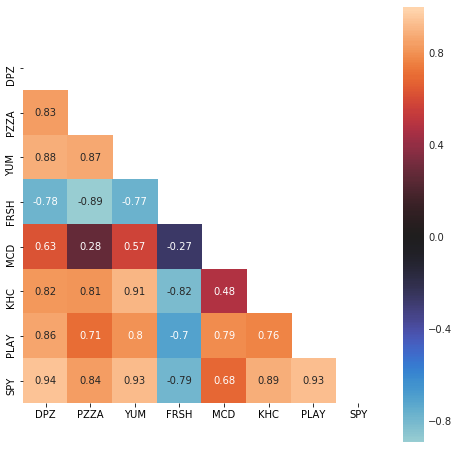

In [7]:
# additional exploratory analysis
# check linear relationships, including SP 500, all move strongly with market except FRSH, strong negative corr
corr = px.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

Pizza Stocks mostly outperform SP 500 Greatly


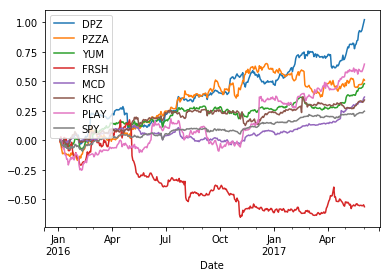

In [8]:
# transform to business day frequency and calculate percentage change
# show cumulative returns over frequency of business days

px = px.asfreq('B').fillna(method='pad') # pad == ffill
rets = px.pct_change()
print('Pizza Stocks mostly outperform SP 500 Greatly')
((1+rets).cumprod()-1).plot()
plt.show()

In [9]:
# compute momentum over a lookback and rank in ASCENDING order and standardize to get portfolio weights
# base code is not momentum out of the box, it is mean reversion, we can change to momentum by changing asc to True
# these form the weights for our portfolio and are based on standardized momentum ranks so we sum to 0 as part of
# our portfolio
# ascending = True - momentum
# ascending = False - mean reversion

def calc_mom(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period, ranks, then standardizes ranks'''
    mom_ret = price.shift(lag).pct_change(lookback) 
    ranks = mom_ret.rank(axis=1, ascending=True)  # rank top performers for each day (asc = momentum)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0) 

Now set up backtesting function to calculate a portfolio 

by iterating over lookbacks and holding period

In [10]:
compound = lambda x : (1+x).prod()-1     # compound calc to give us compound returns for each holding period
daily_sr = lambda x : x.mean() / x.std() # calculate mean portfolio return divided by std deviation to get sharpe


def strat_sr(prices, lb, hold):
    # Compute portfolio weights using rank-standardized momentum portfolio
    freq = '%dB' % hold # set up holding period
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns: aggregate, multiply and take Sharpe ratio
    port = port.shift(1).resample(freq).first() # shift out weights to apply to next period, resample based on holding
    returns = daily_rets.resample(freq).apply(compound) # resample daily returns and calc compound returns for each
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold) 

In [11]:
# sharpe ratio comparison setup
# iterate over combinations of lookback and holding periods from 10 days to 360 days
from collections import defaultdict

lookbacks = range(10, 370, 10)
holdings = range(10, 370, 10)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px.iloc[:, :-1], lb, hold) # dont include S&P in analysis of fast food portfolio
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [12]:
# set up kruskal wallis non-parametric test to formalize if differences between short and intermediate term strategies
from scipy.stats import mstats
short = ddf.iloc[:,:4].values.reshape(-1) # flatten vals to 1D array
inter = ddf.iloc[:,4:].values.reshape(-1)

H, pval = mstats.kruskalwallis(short, inter) # non-par ANOVA
print('Median of short term, intermediate term Sharpe Ratios')
print(np.median(short), np.median(inter))

print('\nNon-parametric ANOVA results for short term vs intermediate term groupings')
print(H, pval)

Median of short term, intermediate term Sharpe Ratios
0.18338060861685285 0.7245688373094721

Non-parametric ANOVA results for short term vs intermediate term groupings
40.62286500495922 1.8463346654379506e-10


In [13]:
# heatmap from book
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

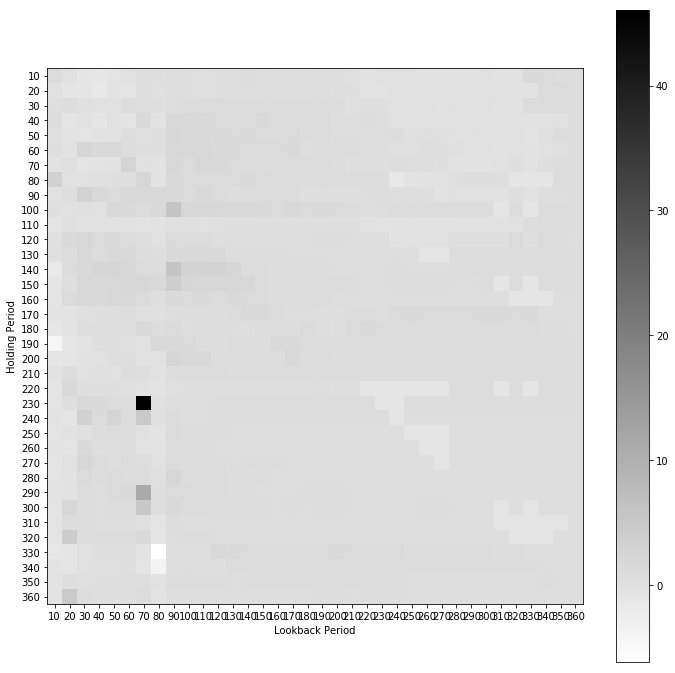

In [14]:
heatmap(ddf)
plt.show()

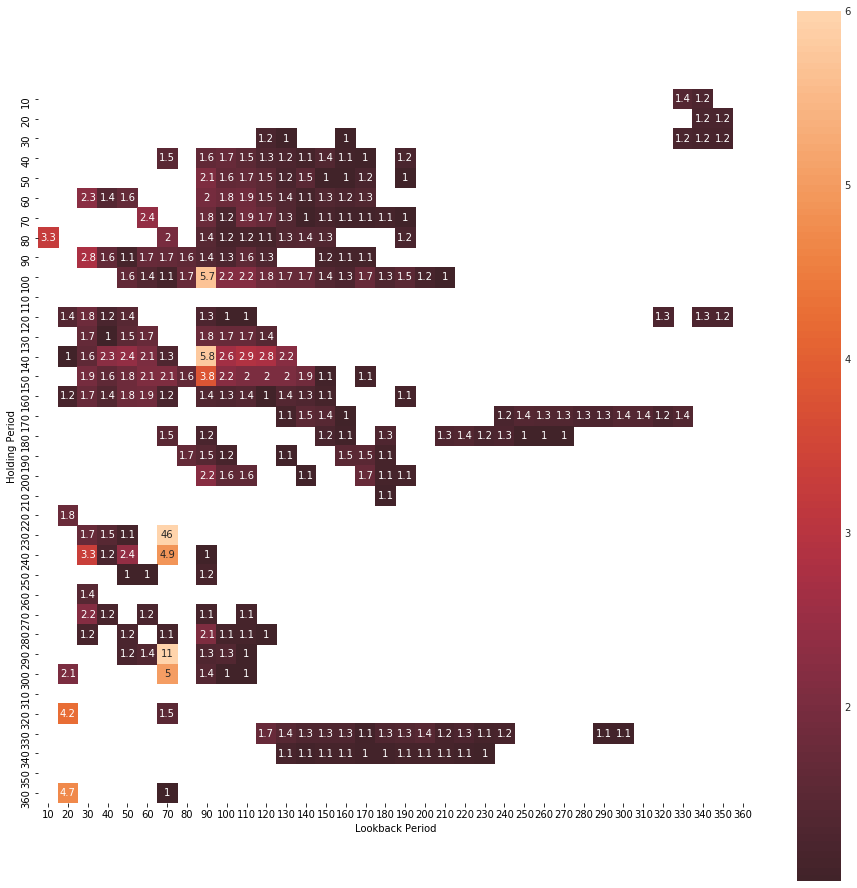

In [15]:
# a better heatmap, clusters around intermediate term lookbacks and holding periods for greater Sharpe Ratios
df = ddf[ddf>1] # show only "good" or above Sharpe ratios
f, ax = plt.subplots(figsize=(16, 16))
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=None, vmax=6, center=0, square=True, annot=True)

# Scratch work for more context

In [16]:
# Calculate S&P cumulative return for same analysis period
((1+px['SPY'].pct_change()).cumprod()-1).iloc[-1]

0.2461370486062533

In [17]:
# Calculate portfolio cumulative return approximation for same analysis period 
# w/equal weight (if we held from day 1 and did not trade momentum)

wts = [.14275, .14275, .14275, .14275, .14275, .14275, .14275]
(((1+px.iloc[:,:-1].pct_change()*wts).cumprod()-1).iloc[-1]).sum() # considering equal weighting

0.33516847450367726

### Annualized Check (should be roughly similar to returns above)

In [18]:
# annualized returns for S&P 500
mean_daily_returns = px.iloc[:,-1].pct_change().mean()
portfolio_return = round(np.sum(mean_daily_returns) * 370, 4)
print('S&P return ',portfolio_return)

S&P return  0.2302


In [19]:
# annualized returns for our portfolio considering equal weights
wts = ([.14275, .14275, .14275, .14275, .14275, .14275, .14275])
mean_daily_returns = px.iloc[:,:-1].pct_change().mean()
portfolio_return = round(np.sum(mean_daily_returns * wts) * 370, 4)
print('Fast food equal weighting return ', portfolio_return)

Fast food equal weighting return  0.3273


Fast food portfolio dominates as expected.

### Now for Sharpe ratio, take good scenario from momentum investing results:

In [20]:
print('Sharpe for one scenario of momentum: ',strat_sr(px.iloc[:,:-1], 90, 100))

Sharpe for one scenario of momentum:  5.6747900846309305


In [21]:
# get S&P sharpe for same periods to compare apples to apples
SP_holding = (px['SPY'].pct_change()).resample('100B').apply(compound)
print('S&P 500 Sharpe: ',SP_holding.mean()/SP_holding.std()*np.sqrt(252 / 100))

S&P 500 Sharpe:  2.5238704183048526


Fast food portfolio has much higher Sharpe for this intermediate term scenario.